c:\Users\user-pc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 10, 'max_iter': 100, 'penalty': 'l2'}
Accuracy: 0.6915838996340826

Classification Report:
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        86
         1.0       0.47      0.42      0.44       215
         2.0       0.49      0.56      0.52       313
         3.0       0.54      0.40      0.46       331
         4.0       0.83      0.96      0.89       968

    accuracy                           0.69      1913
   macro avg       0.47      0.47      0.46      1913
weighted avg       0.65      0.69      0.67      1913



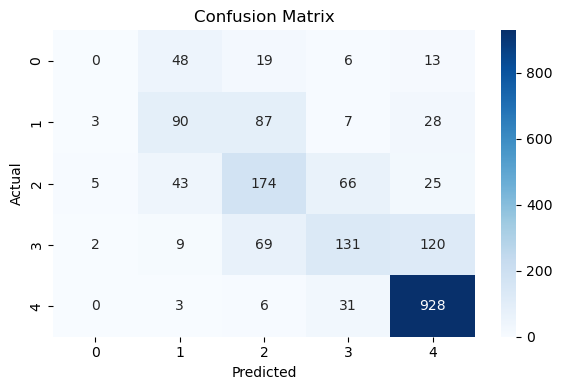

First 20 Predictions:


,Actual,Predicted,Match
0,3.000000,3.000000,True
1,4.000000,4.000000,True
2,4.000000,4.000000,True
3,4.000000,4.000000,True
4,4.000000,4.000000,True
5,1.000000,2.000000,False
6,4.000000,4.000000,True
7,4.000000,4.000000,True
8,1.000000,2.000000,False
9,4.000000,4.000000,True


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import GridSearchCV

#Step 1: Import CSVs
df_train = pd.read_csv('../data/test_data.csv', delimiter=",")
df_test = pd.read_csv('../data/train_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["StudentID", "GradeClass", "GPA"])
y_train = df_train['GradeClass']

X_test = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y_test = df_test['GradeClass']

#Step 3: Feature sclaing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Step 4: Tune and train Logistic Regression model using GridSearchCV

#Define the model
ln = LogisticRegression(solver='lbfgs', max_iter=100)
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],     # Regularization strength
    'penalty': ['l2'],               # Using L2 penalty (default for lbfgs)
    'max_iter': [100, 200, 500]      # Try increasing iterations in case it doesn't converge
}
base_model = LogisticRegression(solver='lbfgs', multi_class='auto')
grid_search = GridSearchCV(base_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Use best model found
ln = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

#Setp 5: predictions
predictions = ln.predict(X_test_scaled)
predictions  #Returns GradeClass based on the columns provided

#Step 6: Evaluation
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

#Confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

#Step 7: Save the model as pkl file in artifacts
with open("../artifacts/regression_model.pkl", "wb") as file:
    pickle.dump(ln, file)
with open("../artifacts/regression_scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

#Step 8: Save predictions to CSV
comparison_df = X_test.copy()
comparison_df["Actual_GradeClass"] = y_test.values
comparison_df["Predicted_GradeClass"] = predictions

#Step 9: Show and save the prediction table

try:
    from IPython.display import display

    # Prepare DataFrame for display
    comparison_df = pd.DataFrame({"Actual": y_test.values,"Predicted": predictions})
    comparison_df["Match"] = comparison_df["Actual"] == comparison_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comparison_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comparison_df.head(20).to_string(index=False))


comparison_df.to_csv("../artifacts/regression_prediction.csv", index=False)
